In [1]:
import torch
from torch import nn
import torch.utils.data as Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from model import Classifier
from preprocessing import Create_Matrix, StandardScaler, Split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
timesteps = 90
batch_size = 512
epochs = 200

In [3]:
sample = pd.read_csv('bdi.csv', parse_dates=['date'], index_col=['date']).fillna(method='ffill').values

In [4]:
label=[0]
for i in range(sample.shape[0]-1):
    if sample[i] < sample[i+1]:
        label.append(1)
    else:
        label.append(0)

In [5]:
x = []
y = []
for i in range(timesteps, sample.shape[0]):
    x.append(sample[i-timesteps:i])
    y.append(label[i])
x = np.array(x)
y = np.array(y).reshape(-1, 1)

In [6]:
x_train, y_train, x_val, y_val, x_test, y_test = Split(x, y)

In [7]:
train = pd.DataFrame(columns=(['chance']), data=y_train) 
train.to_csv('train.csv', index=False, header=True)

In [8]:
scaler = StandardScaler(x_train.reshape(-1))
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [9]:
x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
x_val = torch.FloatTensor(x_val).to(device)
y_val = torch.FloatTensor(y_val).to(device)
x_test = torch.FloatTensor(x_test).to(device)

In [10]:
dataset = Data.TensorDataset(x_train, y_train)
dataloader = Data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [11]:
model = Classifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [12]:
history = dict()
history['loss'] = []
history['val_loss'] = []
best_model = np.inf
for epoch in range(epochs):
    for x_batch, y_batch in dataloader:
        model.train()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    with torch.no_grad():
        model.eval()
        y_pred = model(x_val)
        val_loss = criterion(y_pred, y_val)
        loss = loss.item()
        val_loss = val_loss.item()
    print(f'Epoch:{1+epoch:03d}-loss:{loss:.5f}-val_loss:{val_loss:.5f}')
    if val_loss <= best_model:
        best_model = val_loss
        torch.save(model, 'checkpoint.pt')
        print('weight_saved')
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
model = torch.load('checkpoint.pt')

Epoch:001-loss:0.65676-val_loss:0.64664
weight_saved
Epoch:002-loss:0.61867-val_loss:0.64489
weight_saved
Epoch:003-loss:0.63489-val_loss:0.64286
weight_saved
Epoch:004-loss:0.65258-val_loss:0.64327
Epoch:005-loss:0.65547-val_loss:0.64329
Epoch:006-loss:0.64381-val_loss:0.64305
Epoch:007-loss:0.61851-val_loss:0.64351
Epoch:008-loss:0.62520-val_loss:0.64409
Epoch:009-loss:0.65098-val_loss:0.64291
Epoch:010-loss:0.63159-val_loss:0.64386
Epoch:011-loss:0.64854-val_loss:0.64289
Epoch:012-loss:0.63524-val_loss:0.64684
Epoch:013-loss:0.64650-val_loss:0.64350
Epoch:014-loss:0.64049-val_loss:0.64376
Epoch:015-loss:0.63463-val_loss:0.64326
Epoch:016-loss:0.65036-val_loss:0.64421
Epoch:017-loss:0.63942-val_loss:0.64382
Epoch:018-loss:0.65932-val_loss:0.64315
Epoch:019-loss:0.61140-val_loss:0.64373
Epoch:020-loss:0.66262-val_loss:0.64495
Epoch:021-loss:0.66309-val_loss:0.64287
Epoch:022-loss:0.61083-val_loss:0.64282
weight_saved
Epoch:023-loss:0.62817-val_loss:0.64302
Epoch:024-loss:0.68261-val_l

Epoch:199-loss:0.28156-val_loss:0.45971
Epoch:200-loss:0.26075-val_loss:0.53943


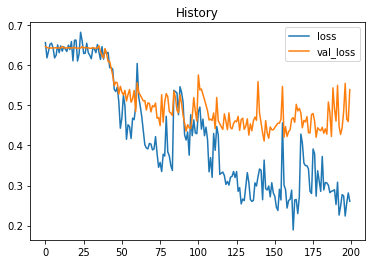

In [13]:
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.title('History')
plt.legend()
plt.show()

In [14]:
with torch.no_grad():
    model.eval()
    pred = model(x_test)
    pred = pred.cpu().numpy()
test = []
for i in pred:
    if i < 0.5:
        test.append(0)
    else:
        test.append(1)
metrics.accuracy_score(y_test, test)

0.8013333333333333

In [15]:
with torch.no_grad():
    model.eval()
    pred = model(x_val)
    pred = pred.cpu().numpy()
val = []
for i in pred:
    if i < 0.5:
        val.append(0)
    else:
        val.append(1)

In [16]:
val = pd.DataFrame(columns=(['chance']), data=val) 
val.to_csv('val.csv', index=False, header=True)
test = pd.DataFrame(columns=(['chance']), data=test) 
test.to_csv('test.csv', index=False, header=True)